In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from os import listdir
from os.path import exists
import time

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import manifold, decomposition

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import *

In [3]:
import cv2

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
# Utilisation d'autre chose que VGG16 car trop lent et surdimensionné pour nous
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
import albumentations as A

In [7]:
from plot_keras_history import show_history, plot_history

# Récupération des données

In [8]:
path_csv = "./data/data_little.csv"
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [9]:
data = pd.read_csv(path_csv)

In [39]:
nb_cat = len(data['cat'].unique())

In [27]:
input_shape = MobileNetV2().input_shape

# Data Augmentation

In [10]:
def cat_to_label(l):
    return np.argmax(l)

In [11]:
# Représentation des vecteurs et catégories en 2D
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat_little), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

## Quelques tests de manipulation d'images

In [12]:
def show_from_cv2(img):
    plt.figure(figsize=(6, 6))
    
    plt.imshow(img)
    
    ax = plt.gca()
    plt.axis("off")
    return plt.show()

In [13]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
 
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

### Tests avec OpenCV

In [14]:
path = data['img'].iloc[0]

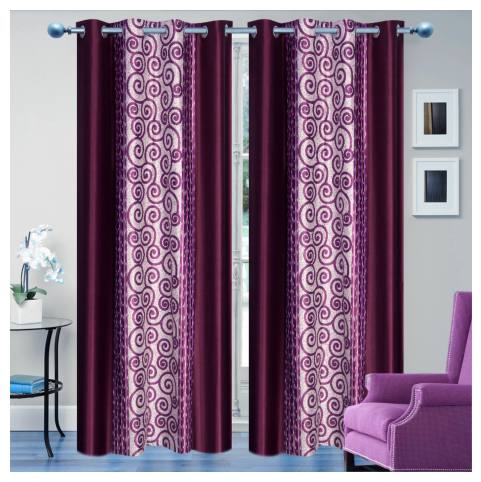

In [15]:
img = cv2.imread(path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
show_from_cv2(img)

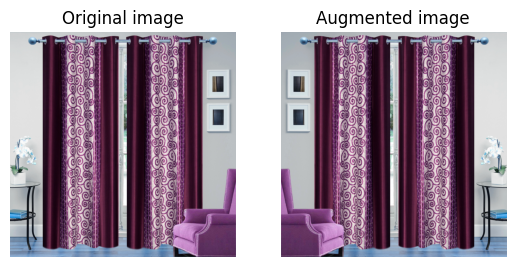

In [16]:
flipped = tf.image.flip_left_right(img)
visualize(img, flipped)

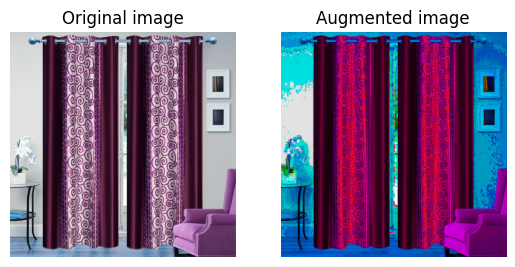

In [17]:
saturated = tf.image.adjust_saturation(img, 256)
visualize(img, saturated)

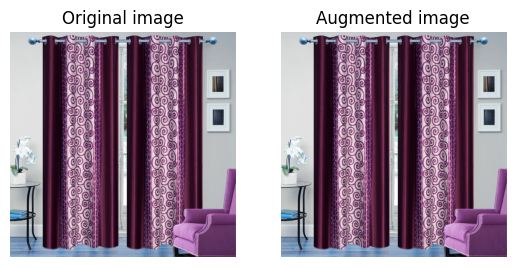

In [18]:
tmp = tf.image.adjust_brightness(img, 0)
visualize(img, tmp)

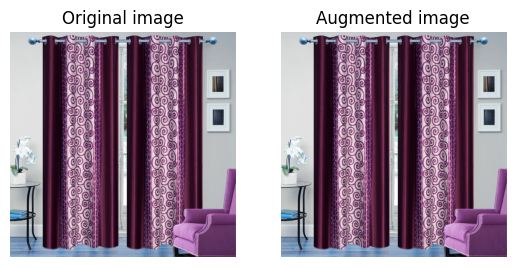

In [19]:
tmp = tf.image.adjust_contrast(img, 1)
visualize(img, tmp)

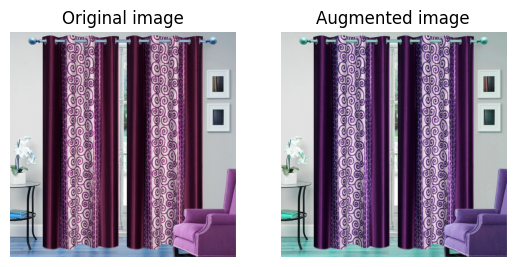

In [20]:
tmp = tf.image.adjust_hue(img, -0.1)
visualize(img, tmp)

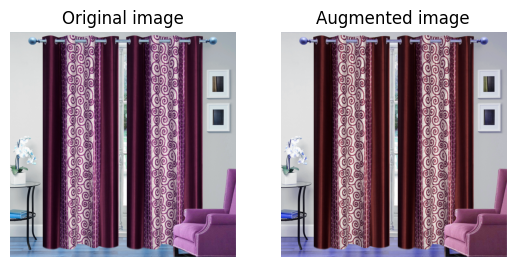

In [22]:
bright = tf.image.stateless_random_hue(img, 0.1, (0, 0))
visualize(img, bright)

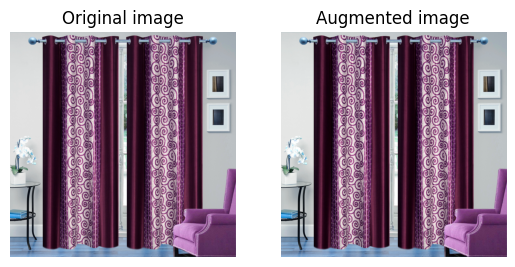

In [23]:
bright = tf.image.stateless_random_contrast(img, 1, 1.1, (0, 2))
visualize(img, bright)

### Test avec Albumentations

In [24]:
transform = A.Compose([
    #A.RandomCrop(width=256, height=256, p=1),
    #A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    #A.CLAHE(),
    #A.RandomRotate90(),
    #A.Transpose(),
    A.ShiftScaleRotate(
        shift_limit=0.02,
        scale_limit=[-0.2, 0.02],
        rotate_limit=0,
        interpolation=cv2.INTER_LANCZOS4,
        border_mode=cv2.BORDER_REFLECT_101,
        value=(255, 255, 255),
        p=0),
    A.Perspective(scale=(0.05, 0.1),
                keep_size=1,
                pad_mode=cv2.BORDER_REFLECT_101,
                pad_val=(255, 255, 255),
                fit_output=0,
                interpolation=cv2.INTER_LANCZOS4,
                p=0),
    A.SafeRotate(
        limit=10,
        interpolation=cv2.INTER_LANCZOS4,
        border_mode=cv2.BORDER_REFLECT_101,
        value=(255, 255, 255),
        p=0),
    #A.PiecewiseAffine(always_apply=False, p=1.0, scale=(0.03, 0.05), nb_rows=(4, 4), nb_cols=(4, 4), interpolation=4, mask_interpolation=0, cval=0, cval_mask=0, mode='wrap', absolute_scale=0, keypoints_threshold=0.01)
    #A.OpticalDistortion(),
    #A.RandomSnow(),
    #A.RandomShadow(),
    #A.RandomBrightnessContrast(p=.75),
    A.ColorJitter(
        brightness=0.1,
        contrast=0.2,
        saturation=0.2,
        hue=0.7,
        p=0.75),
    #A.Blur(blur_limit=1),
    A.GaussNoise(var_limit=(5.0, 50.0), p=0.5),
    A.Downscale(p=0.75, scale_min=0.5, scale_max=0.6, interpolation=cv2.INTER_AREA)
    #A.augmentations.geometric.resize.LongestMaxSize(max(input_shape[1:3])),
])

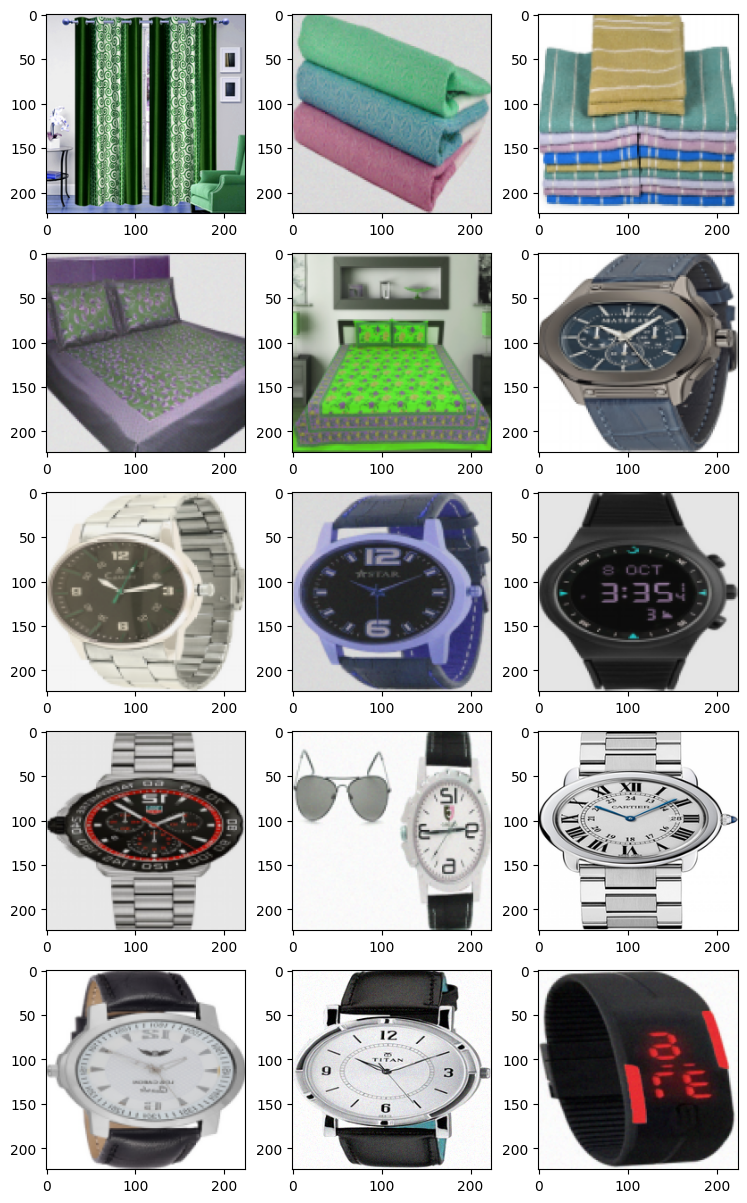

In [28]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))
for i in range(15):
    image = load_img(data['img'].iloc[i], target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    transformed = transform(image=image)
    ax[i // 3, i % 3].imshow(transformed["image"])
plt.show()

## Augmentation

In [34]:
# Conversion des images aux bonnes dimensions et format 
def preprocess_image(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    image = preprocess_input(image)
    return image

In [29]:
def preprocess_image_augmented(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    image = transform(image=image)['image']
    image = preprocess_input(image)
    return image

In [31]:
X_train_img, X_test_img, y_train_label, y_test_label = train_test_split(
    data['img'],
    data['label'],
    test_size=0.33,
    stratify=data['label'])

In [35]:
X_test = list(X_test_img.apply(preprocess_image))
X_test = np.asarray(X_test).astype(np.float32)

In [40]:
y_test = to_categorical(y_test_label, num_classes=nb_cat)

In [41]:
df = pd.DataFrame([X_train_img, y_train_label]).T

In [42]:
df['label'].value_counts()

label
0     100
1      74
2      62
3      58
4      51
5      50
6      43
7      42
8      40
9      38
10     37
11     33
12     27
13     25
14     23
Name: count, dtype: int64

In [43]:
X_augmented = []
y_augmented = []

but = int(np.quantile(df['label'].value_counts().to_list(), 0.8))
print("Nombre minimum d'images dans une classe :", but)
for i, n in df['label'].value_counts().items():
    if n >= but:
        but = n
    
    a_faire = but - n
    liste_images = df.loc[df['label']==i, 'img']
    for path in np.random.choice(liste_images, a_faire):
        img_tmp = preprocess_image_augmented(path)
        X_augmented.append(img_tmp)
        y_augmented.append(i)

X_augmented = np.asarray(X_augmented).astype(np.float32)

Nombre minimum d'images dans une classe : 58


In [44]:
if len(X_augmented) == 0:
    X_augmented = np.ndarray((0,) + input_shape[1:])

In [45]:
for i in range(0):
    X_tmp = df["img"].apply(preprocess_image_augmented)
    X_tmp = np.asarray(list(X_tmp)).astype(np.float32)
    
    X_augmented = np.concatenate((X_augmented, X_tmp))
    
    y_tmp = df["label"].copy()
    
    y_augmented = np.concatenate((y_augmented, y_tmp))

In [46]:
X_train = df["img"].apply(preprocess_image)

In [47]:
X_train = np.asarray(list(X_train)).astype(np.float32)

In [48]:
X_train.shape

(703, 224, 224, 3)

In [49]:
X_train = np.concatenate((X_train, X_augmented))

In [50]:
X_train.shape

(1500, 224, 224, 3)

In [51]:
len(df["label"])

703

In [52]:
y_train = np.concatenate((df["label"], y_augmented))

In [53]:
y_train.shape

(1500,)

In [55]:
y_train = to_categorical(y_train, num_classes=nb_cat)

In [56]:
y_train.shape

(1500, 15)

In [58]:
base_model = MobileNetV2(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [60]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat*4, activation='relu')
prediction_layer = layers.Dense(nb_cat, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    #drop_out,
    dense_layer_2,
    prediction_layer
])

In [61]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=5, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.4, batch_size=16, callbacks=[es])

Epoch 1/20
57/57 [==============================] - 45s 757ms/step - loss: 2.9155 - accuracy: 0.4789 - val_loss: 2.0317 - val_accuracy: 0.4350
Epoch 2/20
57/57 [==============================] - 40s 703ms/step - loss: 1.2119 - accuracy: 0.7222 - val_loss: 1.5709 - val_accuracy: 0.5733
Epoch 3/20
57/57 [==============================] - 40s 708ms/step - loss: 0.8727 - accuracy: 0.7911 - val_loss: 1.5923 - val_accuracy: 0.5867
Epoch 4/20
57/57 [==============================] - 40s 708ms/step - loss: 0.7047 - accuracy: 0.8278 - val_loss: 1.8557 - val_accuracy: 0.5733
Epoch 5/20
57/57 [==============================] - 40s 714ms/step - loss: 0.6078 - accuracy: 0.8733 - val_loss: 1.3271 - val_accuracy: 0.6383
Epoch 6/20
57/57 [==============================] - 42s 734ms/step - loss: 0.7159 - accuracy: 0.8667 - val_loss: 1.2501 - val_accuracy: 0.7017
Epoch 7/20
57/57 [==============================] - 41s 732ms/step - loss: 0.5502 - accuracy: 0.8944 - val_loss: 1.4418 - val_accuracy: 0.6833

## Résultats

In [65]:
start = time.time()
pred_test = model.predict(X_test)
enlapsed = time.time() - start

print("Temps de prédiction (en s): ", round(enlapsed, 2))
print("Nombre de valeurs à prédire : ", len(X_test))
print("Temps moyen par prédiction (en ms): ", int(1000 * enlapsed/len(X_test)))

11/11 [==============================] - 9s 778ms/step
Temps de prédiction (en s):  8.74
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  25


In [66]:
y_test_label = [cat_to_label(e) for e in y_test]
pred_test_label = [cat_to_label(e) for e in pred_test]

In [67]:
print("Accuracy score (taux de classes correctements prédites) sur le set de test :")
accuracy_score(y_test_label, pred_test_label)

Accuracy score (taux de classes correctements prédites) sur le set de test :


0.7118155619596542

In [68]:
print("Accuracy score (taux de classes présentes dans le top 2) sur le set de test :")
top_k_accuracy_score(y_test_label, pred_test, k=2)

Accuracy score (taux de classes présentes dans le top 2) sur le set de test :


0.8011527377521613

In [69]:
print("Score de Cohen kappa sur le set de test :")
cohen_kappa_score(y_test_label, pred_test_label)

Score de Cohen kappa sur le set de test :


0.6867439425125483

In [70]:
print("Coefficient de corrélation de Matthews sur le set de test :")
matthews_corrcoef(y_test_label, pred_test_label)

Coefficient de corrélation de Matthews sur le set de test :


0.6886653589786474

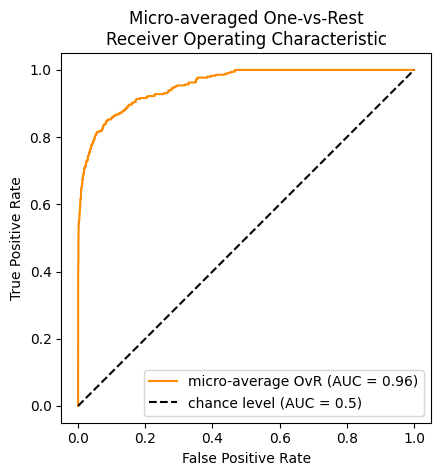

In [71]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Résultats au cas pas cas

In [72]:
labels_little = data.sort_values('label')['cat'].drop_duplicates().to_list()

In [73]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

                            precision    recall  f1-score   support

                   Watches       0.85      1.00      0.92        50
                 Baby Care       0.53      0.67      0.59        36
           Home Furnishing       0.70      0.52      0.59        31
  Beauty and Personal Care       0.81      0.46      0.59        28
          Kitchen & Dining       0.78      0.72      0.75        25
               Coffee Mugs       0.92      0.96      0.94        24
                    Combos       0.95      1.00      0.98        21
                 Computers       0.77      0.81      0.79        21
                Showpieces       0.56      0.70      0.62        20
 Blankets, Quilts & Dohars       0.64      0.74      0.68        19
Home Decor & Festive Needs       0.29      0.11      0.15        19
                   Routers       0.92      0.69      0.79        16
       Baby Girls' Clothes       0.62      0.77      0.69        13
               USB Gadgets       0.77      0.77

Evolution de l'apprentissage

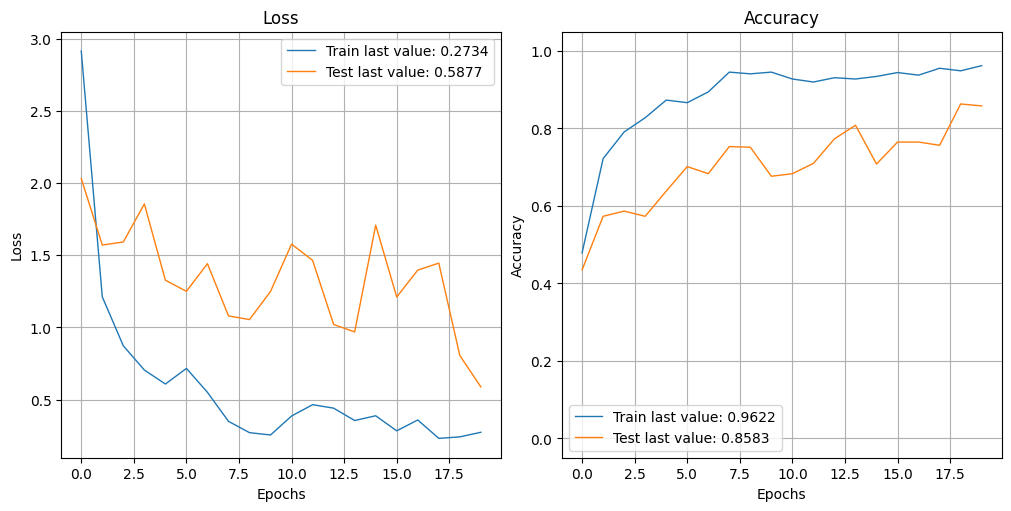

In [74]:
show_history(history)
plt.close()

In [75]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [76]:
def compare_clustering(original, predict, return_cat=False):
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

In [78]:
compare_clustering([labels_little[i] for i in y_test_label], pred_test_label)

ARI :  0.5627594958740696


,pred_0,pred_1,pred_5,pred_6,pred_4,pred_7,pred_2,pred_9,pred_8,pred_3,pred_11,pred_12,pred_13,pred_14,pred_10
cat,,,,,,,,,,,,,,,
Watches,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Baby Care,0,24,0,0,2,0,3,3,0,0,0,2,1,1,0
Coffee Mugs,0,0,23,0,0,0,0,0,0,0,0,0,0,1,0
Combos,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0
Kitchen & Dining,3,2,1,0,18,0,0,0,0,0,0,0,0,1,0
Computers,1,0,0,0,0,17,0,0,0,1,1,0,0,1,0
Home Furnishing,0,9,0,0,0,0,16,2,0,0,0,2,0,2,0
"Blankets, Quilts & Dohars",0,1,0,0,0,0,1,14,1,0,0,2,0,0,0
Showpieces,0,0,0,0,1,0,1,0,14,0,0,0,0,2,2


In [79]:
list_cat, list_col = compare_clustering([labels_little[i] for i in y_test_label], pred_test_label, True)

In [80]:
tmp = pd.DataFrame()

In [81]:
tmp['label'] = [labels_little[i] for i in y_test_label]
tmp['pred'] = [labels_little[i] for i in pred_test_label]

In [82]:
@interact
def show_img(reel=list_cat, predit=list_cat, index=range(0, 10)):
    
    l = list(tmp.loc[(tmp['label']==reel) & (tmp['pred']==predit)].index)
    
    print("Nombre de lignes : ", len(l))
    if index >= len(l):
        return None

    print("Index de cette image dans tmp : ", l[index])
    
    img = cv2.imread(X_test_img.iloc[l[index]])
    h, w = img.shape[:2]
    aspect = h/w
    img = cv2.resize(img, dsize=(400, int(400*aspect)), interpolation=cv2.INTER_CUBIC)
    return show_from_cv2(img)

interactive(children=(Dropdown(description='reel', options=('Watches', 'Baby Care', 'Coffee Mugs', 'Combos', '…